Since we are not tracking m5 by amplifer yet, we need a effective diameter for calculating the area-weighted m5 over the entire field.

Below we first look at the vignetting function, V(r) - unvignetted area as a function of field radius.
Note that we normalize V(r=0) to be 1. Use A for area,

A = A(r=0)* V(r)

So,

D = D(r=0) * sqrt(V(r))

Then we calculate the area-weighted D, which is our effective diameter over the field, D_eff.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [2]:
# read the Excel file, and write the vignetting function to txt. Only needs to be done once.

vfile0 = '../data/vignettingF_doc7512.txt'
if not os.path.isfile(vfile0):
    ExcelFromChuck = '../documentation/EtendueCalculator.xls'
    df = pd.read_excel(ExcelFromChuck, sheet_name='Sheet1',skiprows=3) 
    outerR = np.float64(df['Field Annulus Outer Radius'][1:])
    vigR = np.float64(df['Optical Throughput (from Zemax Vigneting Analysis)'][1:])

    #get rid of the zeros and NaNs
    idx = ~np.isnan(outerR)
    outerR = outerR[idx]
    outerVig = vigR[idx]

    print('Writing to file %s' % vfile0)

    header = '#field radius(deg)   vignetting ratio(0-1)'
    with open(vfile, 'w') as f:
        print(header, file=f)
        for i in range(len(outerR)):
            print(outerR[i], outerVig[i], file=f)

In [3]:
#vignettingF_doc7512.txt doesn't have field points with radius>1.8; 
# also, the values seem a bit different from what I get using v3.3 and v3.11 Zemax models, 
# raytracing 10,000 rays at each field.
# below we use v3.11 values
vfile = '../data/vignettingF.txt'
M1D = 8.36 #clear aperture as in Optical design v3.3
aa = np.loadtxt(vfile, skiprows=12)
r = aa[:,0]
v = aa[:,1]
v0 = v[0]
D0 = (M1D)*np.sqrt(v0)
v = v/v0

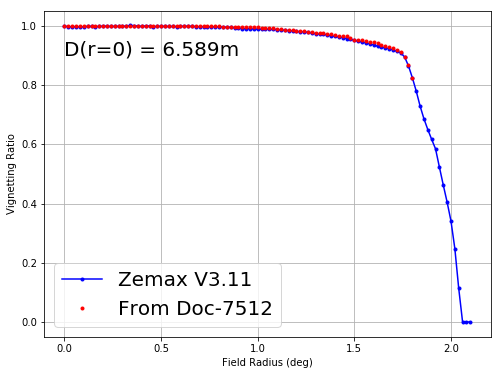

In [4]:
fig1 = plt.figure(figsize=(8, 6))
plt.plot(r, v,'-b.', label='Zemax V3.11')
plt.grid()
plt.xlabel('Field Radius (deg)')
plt.ylabel('Vignetting Ratio')
plt.text(0, .9, 'D(r=0) = %.3fm'%D0, {'fontsize':20})

aa = np.loadtxt(vfile0, skiprows=1)
plt.plot(aa[:,0], aa[:,1]/aa[0,1], 'r.', label='From Doc-7512')
plt.legend(fontsize = 20)

In [5]:
# there has been some inconsistencies in the numbers we've been quoting so far(?)
print('our baseline above (Zemax model v3.11)')
print('\t\t\t D0 = %.2fm, unnormalized V(r=0) = %.3f'%(D0, v0))
M1A = np.pi*((8.36/2)**2 - 2.558**2)
print('using optical design parameters')
print('\t\t\t D0 = %.2fm, unnormalized V(r=0) = %.3f'%(np.sqrt(M1A/np.pi)*2, M1A/(np.pi*(8.36/2)**2) ))
# using values from Document-7512,
#(note that a number of things including hexapods have been adjusted for IQ optimization.)
aa = np.loadtxt(vfile0, skiprows=1)
print('using document-7512 numbers')
print('\t\t\t D0 = %.2fm, unnormalized V(r=0) = %.3f'%(8.406*np.sqrt(aa[0,1]), aa[0,1]))
print('using old LSE-11 numbers (2012 version - 649 rays per field)')
v00 = 0.610169
print('\t\t\t D0 = %.2fm, unnormalized V(r=0) = %.3f'%(np.sqrt(M1A/np.pi)*2, v00))
print('using Zemax model v3.3')
v00 = 0.624092
print('\t\t\t D0 = %.2fm, unnormalized V(r=0) = %.3f'%((M1D)*np.sqrt(v00), v00))
print('SRD Appendix A:')
print('\t\t\t D0 = 6.68m')

our baseline above (Zemax model v3.11)
			 D0 = 6.59m, unnormalized V(r=0) = 0.621
using optical design parameters
			 D0 = 6.61m, unnormalized V(r=0) = 0.626
using document-7512 numbers
			 D0 = 6.58m, unnormalized V(r=0) = 0.612
using old LSE-11 numbers (2012 version - 649 rays per field)
			 D0 = 6.61m, unnormalized V(r=0) = 0.610
using Zemax model v3.3
			 D0 = 6.60m, unnormalized V(r=0) = 0.624
SRD Appendix A:
			 D0 = 6.68m


put down a dense grid and check what fraction of the points land on chips

In [6]:
from lsst.obs.lsstSim import LsstSimMapper
from lsst.sims.coordUtils import chipNameFromRaDec
from lsst.sims.utils import ObservationMetaData
from lsst.sims.utils import angularSeparation

In [35]:
mapper = LsstSimMapper()
epoch=2000.
ra, dec = np.meshgrid(np.linspace(-2.1,2.1, 525), np.linspace(-2.1,2.1, 525))
obs_metadata = ObservationMetaData(pointingRA=np.degrees(0.),
                                                   pointingDec=np.degrees(0.),
                                                   rotSkyPos=np.degrees(0.),
                                                   mjd=53000)

In [36]:
chipNames = chipNameFromRaDec(ra.ravel(),dec.ravel(),epoch=epoch, camera=mapper.camera, obs_metadata=obs_metadata)

In [37]:
radius = angularSeparation(0., 0., ra.ravel(), dec.ravel())
v2d = np.interp(radius, r, v)

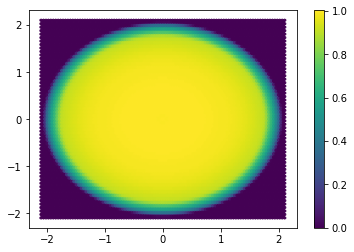

In [38]:
plt.hexbin(ra.ravel(), dec.ravel(), v2d)
plt.colorbar()

In [39]:
good = np.where((chipNames != [None]))
# Check for other bits
cng = np.array(chipNames[good], dtype='str')
find_char1 = np.char.find(cng, 'R:0,0')
find_char2 = np.char.find(cng, 'R:4,4')
find_char3 = np.char.find(cng, 'R:4,0')
find_char4 = np.char.find(cng, 'R:0,4')

good2 = np.where((find_char1 == -1) & (find_char2 == -1)
                & (find_char3 == -1) & (find_char4 == -1))
good = good[0][good2]
bad = np.where(chipNames == [None])

(-2.3159139784946237,
 2.3159139784946237,
 -2.3175883002207507,
 2.3175883002207507)

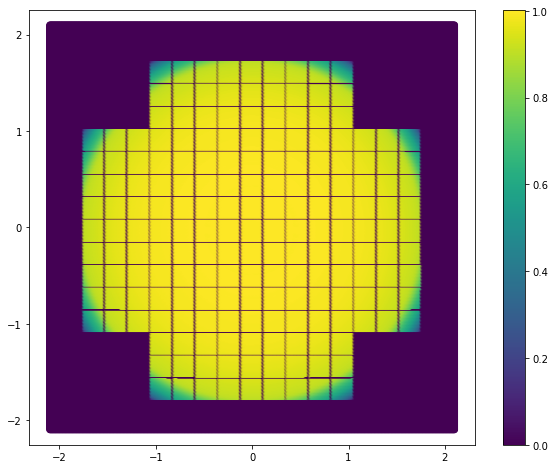

In [40]:
plt.figure(figsize=(10, 8))
ack = ra.ravel()*0
ack[good] = 1
plt.scatter(ra.ravel(), dec.ravel(), c= v2d*ack)
#plt.hexbin(ra.ravel(), dec.ravel(), v2d*ack, gridsize=500)
plt.colorbar()
plt.axis('equal')
#plt.xlim([-0.5, 0.5])
#plt.ylim([-0.5, 0.5])

In [41]:
Deff = D0*np.mean(np.sqrt(v2d[good]))
print('the effective D= %.3fm'%(Deff))

the effective D= 6.404m


Now, to calculate m5, we need the syseng_throughput repo

In [42]:
import lsst.syseng.throughputs as st
from lsst.sims.photUtils import Bandpass
from lsst.utils import getPackageDir

In [43]:
masterdir = getPackageDir('syseng_throughputs')
masterDirs = st.setDefaultDirs(rootDir=masterdir)
master_hardware, master_system = st.buildHardwareAndSystem(masterDirs)

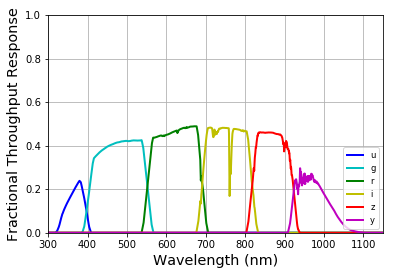

In [44]:
st.plotBandpasses(master_system, addlegend=True)

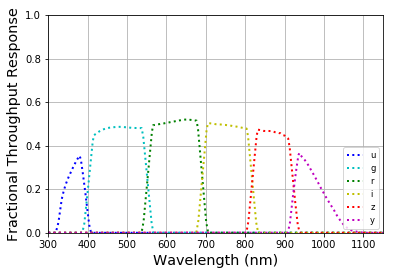

In [45]:
st.plotBandpasses(master_hardware, linestyle=':', addlegend=True)

In [46]:
master_m5 = st.makeM5(master_hardware, master_system, darksky=None, 
                      exptime=15, nexp=2, readnoise=8.8, othernoise=0, darkcurrent=0.2,
                      effarea=np.pi*(Deff/2*100)**2, X=1.0)

In [47]:
master_m5

,FWHMeff,FWHMgeom,skyMag,skyCounts,Zp_t,Tb,Sb,kAtm,gamma,Cm,dCm_infinity,dCm_double,m5,sourceCounts,m5_fid,m5_min
u,0.92,0.80824,22.988641,68.703884,26.872521,0.031784,0.050870,0.510620,0.038139,23.042289,0.633541,0.406785,23.739884,537.249146,23.9,23.4
g,0.87,0.76714,22.256461,400.331172,28.369532,0.126188,0.151018,0.195025,0.038731,24.428529,0.180164,0.095386,24.820707,788.226735,25.0,24.6
r,0.83,0.73426,21.196219,805.001138,28.158597,0.103907,0.114369,0.104161,0.038983,24.456486,0.097576,0.048534,24.369645,983.336057,24.7,24.3
i,0.80,0.70960,20.477858,1137.433788,27.846063,0.077917,0.083386,0.073658,0.039089,24.344032,0.070961,0.034187,23.937981,1097.372282,24.0,23.6
z,0.78,0.69316,19.599677,1703.370645,27.432248,0.053224,0.055617,0.047748,0.039219,24.174705,0.048500,0.022494,23.357052,1279.970431,23.3,22.9
y,0.76,0.67672,18.611811,2268.912630,26.640221,0.025662,0.029824,0.163181,0.039297,23.733861,0.036854,0.016562,22.450478,1422.389994,22.1,21.7


In [48]:
m5 = np.array(master_m5.m5)

In [49]:
# the 0th order calculation Bo has been showing at summer 2018 reviews:
m5SRD = np.array([23.9, 25.0, 24.7, 24.0, 23.3, 22.1])
#m5SRDmin = []
#m5 = np.array([23.78, 24.81, 24.35, 23.92, 23.34, 22.45])
# Nv1 from SRD table 24
Nv1 = np.array([56, 80, 184, 184, 160, 160])
omega = Nv1/sum(Nv1)
fS = sum(omega*10**(0.8*(m5 - m5SRD)))
print('Current estimate: fS = %.2f'%fS)

Current estimate: fS = 1.03


In [51]:
#how much change do we expect when D_eff goes from 6.423 to 6.404?
print('%.3f'%(6.401/6.423)**2)

0.993
